# 3D AutoencoderKL

In [1]:
%cd /mnt_homes/home4T7/jdafflon/GenerativeModels

/mnt_homes/home4T7/jdafflon/GenerativeModels


## Setup imports

In [2]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import autocast
from tqdm import tqdm

from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL

print_config()

/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.dev2239
Numpy version: 1.23.4
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 13b24fa92b9d98bd0dc6d5cdcb52504fd09e297b
MONAI __file__: /home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, plea

In [3]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset

Specify a `MONAI_DATA_DIRECTORY` variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = "/tmp/tmpyxyg6wxs"
print(root_dir)

/tmp/tmpyxyg6wxs


## Download the training set

Note: The DecatholonDataset has 7GB. So make sure that you have enought space when running the next line

In [5]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image"],
            pixdim=(2.0, 2.0, 2.0),
            mode=("bilinear"),
        ),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(100, 100, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",
    cache_rate=1.0,
    num_workers=4,
    download=False,
    seed=0,
    transform=train_transforms,
)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
print(f'Image shape {train_ds[0]["image"].shape}')

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████| 388/388 [03:02<00:00,  2.12it/s]

Image shape (4, 100, 100, 64)


## Visualise examples from the training set

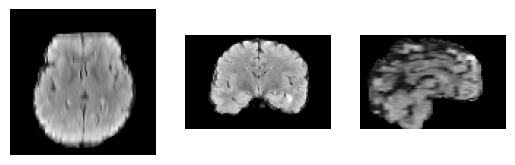

In [6]:
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx, channel]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2].rot90(), cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...].rot90(), cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...].rot90(), cmap="gray")

## Download the validation set

In [7]:
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image"],
            pixdim=(2.0, 2.0, 2.0),
            mode=("bilinear"),
        ),
        transforms.CenterSpatialCropd(keys=["image"], roi_size=(100, 100, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
    ]
)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,
    seed=0,
    transform=val_transforms,
)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=4)
print(f'Image shape {val_ds[0]["image"].shape}')

2022-11-27 23:46:43,754 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-11-27 23:46:43,757 - INFO - File exists: /tmp/tmpyxyg6wxs/Task01_BrainTumour.tar, skipped downloading.
2022-11-27 23:46:43,758 - INFO - Non-empty folder exists in /tmp/tmpyxyg6wxs/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████████| 96/96 [00:46<00:00,  2.07it/s]

Image shape (4, 100, 100, 64)


## Define the network

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=64,
    latent_channels=8,
    ch_mult=(1, 2, 3),
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
model.to(device)

perceptual_loss = PerceptualLoss(spatial_dims=3, network_type="squeeze", fake_3d_ratio=0.25)
perceptual_loss.to(device)

Using cuda


/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jdafflon/miniconda3/envs/genmodels/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PerceptualLoss(
  (perceptual_function): LPIPS(
    (scaling_layer): ScalingLayer()
    (net): squeezenet(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
        (1): ReLU(inplace=True)
      )
      (slice2): Sequential(
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        (3): Fire(
          (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (squeeze_activation): ReLU(inplace=True)
          (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (expand1x1_activation): ReLU(inplace=True)
          (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (expand3x3_activation): ReLU(inplace=True)
        )
        (4): Fire(
          (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
          (squeeze_activation): ReLU(inplace=True)
          (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (exp

In [9]:
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

In [10]:
scaler = torch.cuda.amp.GradScaler()

## Model training

In [11]:
kl_weight = 1e-6
optimizer = torch.optim.Adam(model.parameters(), 2.5e-5)
n_epochs = 10
val_interval = 2
epoch_loss_list = []
val_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        # select only one channel from the Decathlon dataset
        one_channel = batch["image"][:, None, channel, ...]
        images = one_channel.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = model(images)

            mse_loss = F.mse_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())

            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

            # TODO: Add adversarial component
            loss = mse_loss + kl_weight * kl_loss + perceptual_weight * p_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                # select only one channel from the Decathlon dataset
                one_channel = batch["image"][:, None, channel, ...]
                images = one_channel.to(device)
                optimizer.zero_grad(set_to_none=True)
                reconstruction, z_mu, z_sigma = model(images)
                # get the first sammple from the first validation batch for visualisation
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])

                mse_loss = F.mse_loss(reconstruction.float(), images.float())
                p_loss = perceptual_loss(reconstruction.float(), images.float())

                kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
                kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]

                # TODO: Add adversarial component
                loss = mse_loss + kl_weight * kl_loss + perceptual_weight * p_loss
                val_loss += loss.item()

        val_loss /= val_step
        val_epoch_loss_list.append(val_loss)

        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

Epoch 1: 100%|█████████| 194/194 [08:48<00:00,  2.72s/it, loss=0.0144]


epoch 2 val loss: 0.0134


Epoch 3: 100%|█████████| 194/194 [08:46<00:00,  2.71s/it, loss=0.0114]


epoch 4 val loss: 0.0114


Epoch 5: 100%|█████████| 194/194 [08:47<00:00,  2.72s/it, loss=0.0102]


epoch 6 val loss: 0.0109


Epoch 7: 100%|████████| 194/194 [08:48<00:00,  2.72s/it, loss=0.00967]


epoch 8 val loss: 0.0101


Epoch 9: 100%|█████████| 194/194 [08:47<00:00,  2.72s/it, loss=0.0093]


epoch 10 val loss: 0.0101


## Evaluate the trainig

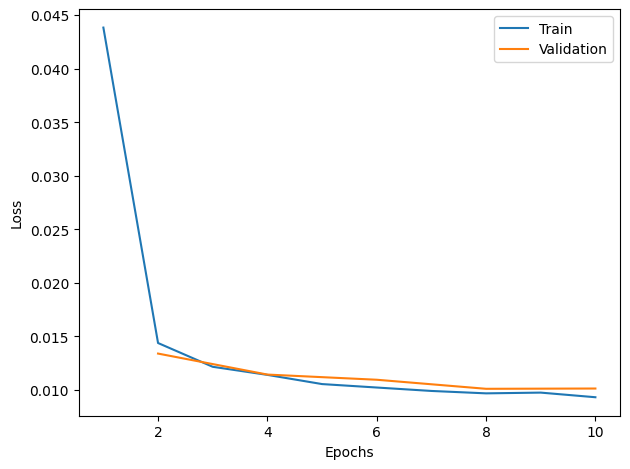

In [12]:
plt.figure()
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, label="Train")
plt.plot(val_samples, val_epoch_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

### Visualise some reconstruction images

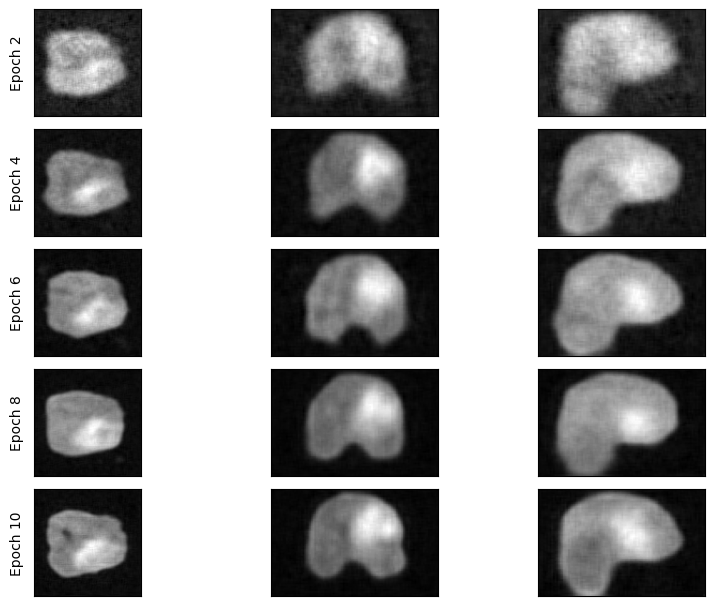

In [13]:
img = check_data["image"][idx, channel]
fig, axs = plt.subplots(nrows=len(intermediary_images), ncols=3, constrained_layout=True, figsize=(8, 6))

# Remove ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

for image_n in range(len(intermediary_images)):
    axs[image_n, 0].imshow(intermediary_images[image_n][0, ..., img.shape[2] // 2].cpu(), cmap="gray")
    axs[image_n, 1].imshow(intermediary_images[image_n][0, :, img.shape[1] // 2, ...].cpu().rot90(), cmap="gray")
    axs[image_n, 2].imshow(intermediary_images[image_n][0, img.shape[0] // 2, ...].cpu().rot90(), cmap="gray")
    axs[image_n, 0].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

In [16]:
images[0, 0, ..., img.shape[2] // 2].cpu().shape

(100, 100)

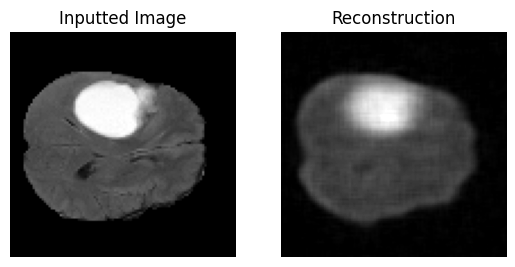

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0, 0, ..., img.shape[2] // 2].cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, 0, ..., img.shape[2] // 2].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

## Clean up data directory

Remove directory if a temporary storage was used

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)